In [63]:
#load packages 
import numpy as np
import pandas as pd
import scipy
from PIL import Image
import glob
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [108]:
#grab file path names
image_paths = glob.glob("../data/movie-genre-from-its-poster/SampleMoviePosters/SampleMoviePosters/*.jpg")
image_ids = []
for path in image_paths:
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids.append(path[start:end])

In [109]:
df_movie = pd.read_csv("../data/movie-genre-from-its-poster/MovieGenre.csv", encoding = "ISO-8859-1")

In [110]:
df_movie.shape

(40108, 6)

In [111]:
df_movie.head(1)

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...


In [112]:
df_movie_sample = df_movie[df_movie["imdbId"].isin(image_ids)]
df_movie_sample = df_movie_sample.drop_duplicates(subset=['imdbId'], keep="last")

In [113]:
df_movie_sample.shape

(997, 6)

In [114]:
df_movie_sample["Genre"] = df_movie_sample["Genre"].str.split("|")

In [115]:
X = df_movie_sample.drop("Genre", axis =1)
y = df_movie_sample["Genre"]

In [116]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
target_key = mlb.classes_

In [117]:
images = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in image_paths])

In [118]:
images = images.astype('float32')/255.0

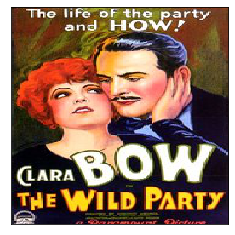

In [119]:
#sample image
plt.imshow(images[0]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);

In [131]:
target_labels = target_key
total_classes = len(set(target_labels))
print("number of genre:", total_classes)

number of genre: 23


In [120]:
len(image_ids)

997

In [121]:
images.shape

(997, 256, 256, 3)

In [122]:
y.shape

(997, 23)

In [123]:
X_train, X_valid, y_train, y_valid = train_test_split(images, y, 
                                                     random_state=42)

In [127]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [141]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(total_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

In [142]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 747 samples, validate on 250 samples
Epoch 1/10
 32/747 [>.............................] - ETA: 1s

TypeError: Expected int64 passed to parameter 'y' of op 'Maximum', got 1e-12 of type 'float' instead. Error: Expected int64, got 1e-12 of type 'float' instead.

In [140]:
img_test_predict = np.reshape(images[0], (1, 256, 256, 3))
model.predict(img_test_predict)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)